In [22]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.api import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.lines import Line2D
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

Import raw data from local drive. 

In [3]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

## Prepare Data

Calculate mean relief of each transect. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 1.5, respectively. 

In [4]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

Clean and prepare fish data. Calculate weighted size using size class data and pivot fish variables into workable format. 

In [52]:
fish_master = fish.merge(species_codes, on='Species', how='right')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'right')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Species,Size_cm,Count,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Post-Kelp,1_hour,SSER,25,1,Olive rockfish,Midwater,2.2,High
1,2,Pre-Kelp,0_hours,SMYS,15,6,Blue rockfish,Midwater,2.2,High
2,2,Pre-Kelp,0_hours,SMYS,20,6,Blue rockfish,Midwater,2.2,High
3,2,Post-Kelp,1_hour,SMYS,5,1,Blue rockfish,Midwater,2.2,High
4,2,Post-Kelp,1_hour,SMYS,15,4,Blue rockfish,Midwater,2.2,High
...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,HDEC,30,1,Kelp greenling,Benthic,1.5,High
167,11,Pre-Kelp,0_hours,OPIC,15,1,Painted greenling,Benthic,1.5,High
168,11,Post-Kelp,1_hour,OPIC,5,1,Painted greenling,Benthic,1.5,High
169,11,Pre-Kelp,0_hours,ELAT,15,11,Striped surfperch,Bentho-pelagic,1.5,High


In [99]:
treatment_mobility = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Mobility']).apply(
    lambda g: pd.Series({
        'abundance': g['Count'].sum(),
        'density': g['Count'].sum() / 20,
        'richness': g['Species'].nunique(),
        'weighted_size': np.average(g['Size_cm'], weights=g['Count']) if g['Count'].sum() > 0 else np.nan,
        'biodiversity': -np.sum((p := g.groupby('Species')['Count'].sum() / g['Count'].sum()) * np.log(p))
    })
).reset_index()


# Step 2: Calculate mean (± SE) of each metric by Treatment and Mobility
summary_stats = treatment_mobility.groupby(['Treatment_Time', 'Mobility']).agg(
    density_mean=('density', 'mean'),
    density_se=('density', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    
    richness_mean=('richness', 'mean'),
    richness_se=('richness', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    
    size_mean=('weighted_size', 'mean'),
    size_se=('weighted_size', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    
    biodiversity_mean=('biodiversity', 'mean'),
    biodiversity_se=('biodiversity', lambda x: x.std(ddof=1) / np.sqrt(len(x)))
).reset_index()


/var/folders/4m/01lfdwy93kb5805s3g5v2pkw0000gn/T/ipykernel_56766/3447275714.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treatment_mobility = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Mobility']).apply(


,Treatment_Time,Mobility,density_mean,density_se,richness_mean,richness_se,size_mean,size_se,biodiversity_mean,biodiversity_se
0,0_hours,Benthic,0.168750,0.038888,1.875000,0.295048,15.200893,2.319436,0.484764,0.161566
1,0_hours,Bentho-pelagic,0.150000,0.058926,1.444444,0.175682,23.009259,2.375140,0.262920,0.111896
2,0_hours,Midwater,1.116667,0.239212,1.000000,0.000000,9.536518,0.633894,0.000000,0.000000
3,1_hour,Benthic,0.242857,0.049315,2.571429,0.297381,12.452381,1.276421,0.803808,0.104376
4,1_hour,Bentho-pelagic,0.131250,0.038888,1.500000,0.377964,19.008929,2.759506,0.231523,0.171594
5,1_hour,Midwater,1.130000,0.260896,1.200000,0.133333,11.454367,1.117645,0.057255,0.039293
6,1_week,Benthic,0.280000,0.046368,2.800000,0.374166,11.505952,1.654655,0.868809,0.140520
7,1_week,Bentho-pelagic,0.235714,0.146675,1.428571,0.297381,24.142857,3.487587,0.234774,0.154121
8,1_week,Midwater,0.978571,0.273395,1.000000,0.000000,9.735352,1.091405,0.000000,0.000000


In [96]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# List of metrics to test
metrics = ['density', 'richness', 'weighted_size', 'biodiversity']

# Loop through each metric and run ANOVA and post hoc if significant
for metric in metrics:
    print(f"Testing for {metric}...")
    
    # Perform two-way ANOVA with interaction between Treatment_Time and Mobility
    formula = f"{metric} ~ C(Treatment_Time) * C(Mobility)"
    model = ols(formula, data=treatment_mobility).fit()
    anova_table = anova_lm(model, typ=2)  # Type II sum of squares
    print(f"ANOVA for {metric} by Treatment_Time and Mobility (with Interaction):")
    print(anova_table)

    # Check if the interaction term is significant
    interaction_p_value = anova_table.loc['C(Treatment_Time):C(Mobility)', 'PR(>F)']
    
    if interaction_p_value < 0.05:
        print("  → Significant interaction between Treatment_Time and Mobility (p < 0.05)")

        # If the interaction is significant, perform Tukey's HSD test for post hoc analysis
        data = summary_stats[[metric, 'Treatment_Time', 'Mobility']]
        
        # Create a combined 'Treatment_Time_Mobility' group column
        data['Treatment_Mobility'] = data['Treatment_Time'].astype(str) + "_" + data['Mobility'].astype(str)

        # Tukey HSD test
        tukey = pairwise_tukeyhsd(endog=data[metric], groups=data['Treatment_Mobility'], alpha=0.05)

        # Print Tukey HSD results
        print("\nPost Hoc Tukey HSD Test Results:")
        print(tukey.summary())
    else:
        print("  → No significant interaction (p ≥ 0.05)")
    
    print()

    # Now, check for main effects of Treatment_Time and Mobility
    if anova_table.loc['C(Treatment_Time)', 'PR(>F)'] < 0.05:
        print(f"  → Significant effect of Treatment_Time (p < 0.05)")

    if anova_table.loc['C(Mobility)', 'PR(>F)'] < 0.05:
        print(f"  → Significant effect of Mobility (p < 0.05)")
    
    print("\n" + "-"*50 + "\n")


Testing for density...
ANOVA for density by Treatment_Time and Mobility (with Interaction):
                                  sum_sq    df          F        PR(>F)
C(Treatment_Time)               0.007243   2.0   0.014872  9.852418e-01
C(Mobility)                    12.960034   2.0  26.612203  4.908097e-09
C(Treatment_Time):C(Mobility)   0.189666   4.0   0.194731  9.402402e-01
Residual                       14.853375  61.0        NaN           NaN
  → No significant interaction (p ≥ 0.05)

  → Significant effect of Mobility (p < 0.05)

--------------------------------------------------

Testing for richness...
ANOVA for richness by Treatment_Time and Mobility (with Interaction):
                                  sum_sq    df          F        PR(>F)
C(Treatment_Time)               1.329647   2.0   1.506148  2.298933e-01
C(Mobility)                    19.182366   2.0  21.728688  7.497512e-08
C(Treatment_Time):C(Mobility)   2.099047   4.0   1.188840  3.247777e-01
Residual                

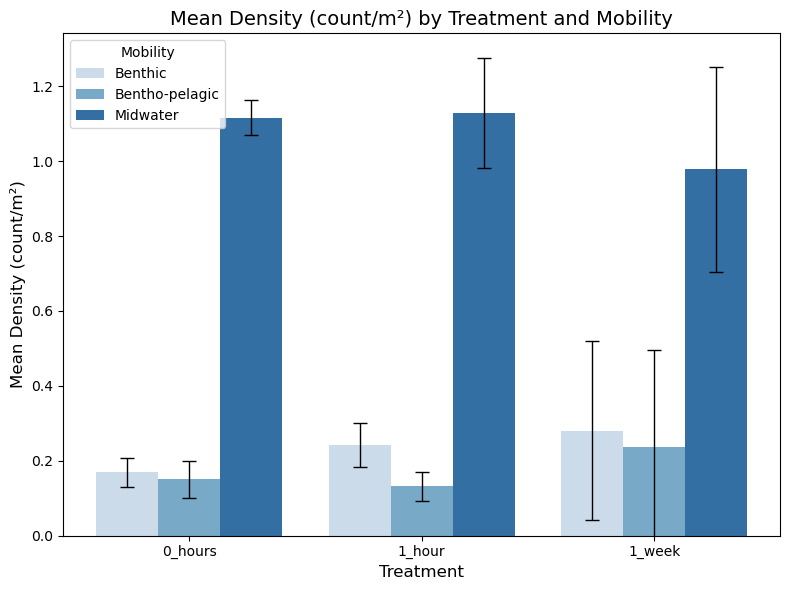

✅ Plot displayed and saved for: density_mean


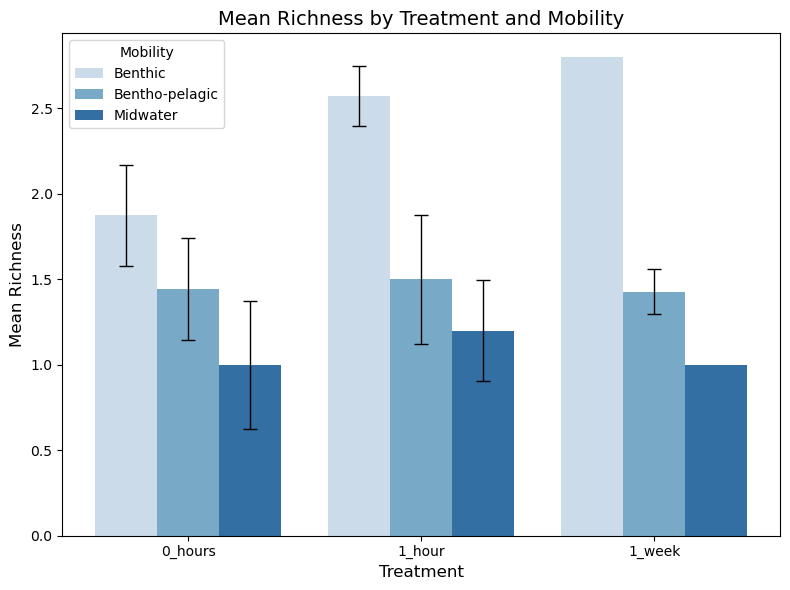

✅ Plot displayed and saved for: richness_mean


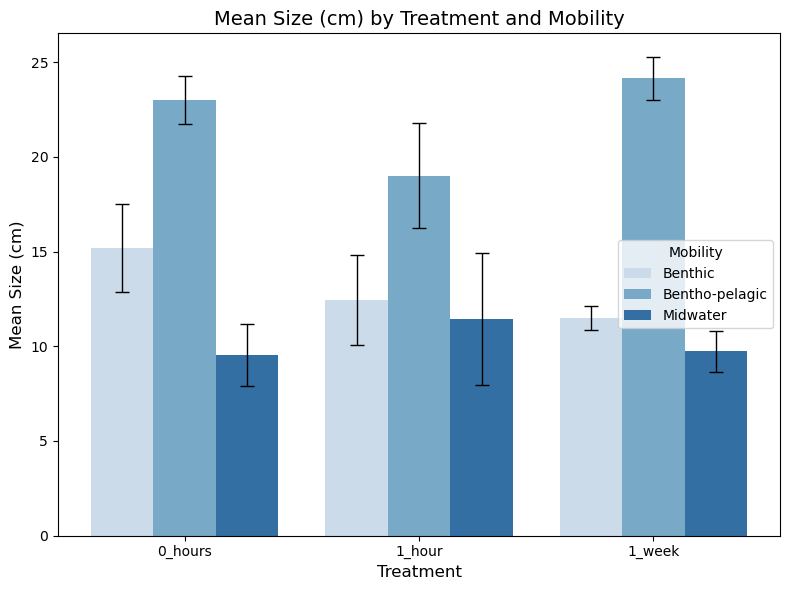

✅ Plot displayed and saved for: size_mean


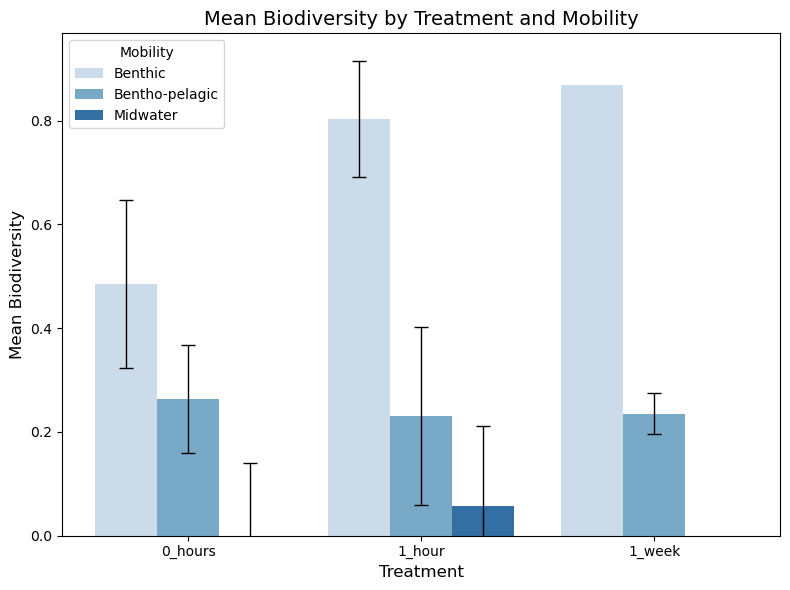

✅ Plot displayed and saved for: biodiversity_mean


In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics and their labels
metrics = {
    'density_mean': ('density_se', 'Mean Density (count/m²)'),
    'richness_mean': ('richness_se', 'Mean Richness'),
    'size_mean': ('size_se', 'Mean Size (cm)'),
    'biodiversity_mean': ('biodiversity_se', 'Mean Biodiversity')
}

# Loop through each metric
for metric, (se_col, y_label) in metrics.items():
    # Sort to ensure consistent order
    data = summary_stats.sort_values(by=['Treatment_Time', 'Mobility'])

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=data,
        x='Treatment_Time',
        y=metric,
        hue='Mobility',
        palette='Blues',
        errorbar=None  # <-- replaces deprecated 'ci=None'
    )

    # Add error bars using precomputed SE values
    for bar, (_, row) in zip(ax.patches, data.iterrows()):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        err = row[se_col]

        if pd.notna(err) and err > 0:
            ax.errorbar(x, y, yerr=err, fmt='none', c='black', capsize=5, elinewidth=1)

    # Format plot
    plt.title(f"{y_label} by Treatment and Mobility", fontsize=14)
    plt.xlabel('Treatment', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.ylim(bottom=0)
    plt.legend(title='Mobility')
    plt.tight_layout()

    # Save the figure with correct filename
    filename = f'{metric}_treatment_by_mobility_plot.jpg'
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')

    plt.show()

    print(f"✅ Plot displayed and saved for: {metric}")
